# YouTube Watch History Data Analysis

### Introduction

YouTube has become an essential part of many people's daily lives. It serves as a platform for entertainment, learning, and relaxation. This project focuses on analyzing YouTube watch history data to gain insights into viewing patterns and habits.

### Project Goals
This project aims to achieve general descriptive approaches to provide a comprehensive understanding of YouTube usage habits.

### The source dataset

The dataset for this analysis was created using a two-step process that involved web scraping and API requests to gather comprehensive information about the YouTube watch history.

First, I used a Python script called youtube_scraper.py to extract data from an HTML file of my YouTube History. This HTML file was obtained through Google Takeout, which provides a detailed export of a user's YouTube activity. Using the BeautifulSoup library, the script parsed the HTML file to extract essential information for each video, including the video title, URL, the time it was played, the channel that posted it, and the channel's URL. This information was then saved into a CSV file named 'youtube_data.csv'.

However, the HTML file from Google Takeout did not provide all the details I wanted for my analysis. To enrich the dataset with additional information, I created another Python script named youtube_api.py. This script aimed to fill in the gaps by fetching more data through the YouTube Data API. For each video entry in history.csv, the script extracted the video ID from the URL. With the video ID in hand, the script made API requests to gather further details such as the video's duration, the number of likes it had received, and the total number of comments. This additional data provided a more comprehensive view of each video that will allow us to perform deeper analysis.

### Extraction Process

1. **Google Takeout**:
    - The initial dataset was downloaded from Google Takeout, which provided an HMTL file containing basic information about each video watched, including the video title, timestamp, link, and channel name.

2. **YouTube API**:
    - Using the video IDs extracted from the Google Takeout dataset, the YouTube Data API was used to retrieve additional information. 
    - A script was written in Python to interact with the YouTube Data API. This script performed the following steps:
        1. **Authenticate**: Connect to the YouTube Data API using an API key.
        2. **Request Data**: For each video ID, send a request to the YouTube API to fetch video details.
        3. **Parse Response**: Extract relevant information from the API response, such as video tags, number of likes, number of comments, and other metadata.
        4. **Merge Data**: Combine the additional information from the YouTube API with the original Google Takeout data to create a more comprehensive dataset and output it in a CSV file.

## Project Structure

- **Data Collection**: Scripts and notebooks for extracting and collecting data from Google Takeout.
- **Data Cleaning**: Steps to clean and preprocess the data to ensure it is ready for analysis.
- **Data Analysis**: Notebooks containing analysis and visualizations to uncover insights and trends.
- **Results**: Summary of findings and key takeaways from the analysis.

## How to Use

1. **Clone the Repository**: `git clone https://github.com/your-username/your-repository.git`
2. **Install Dependencies**: `pip install -r requirements.txt`
3. **Run Notebooks**: Open and run the Jupyter Notebooks to reproduce the analysis.

## Requirements

- Python 3.x
- Jupyter Notebook
- pandas
- numpy
- matplotlib
- seaborn

# Before we begin
I'd like to inform you that the results and insights presented here might not fully correspond to realistic viewing habits due to several factors that can affect data integrity. For example, if you use multiple YouTube accounts, the data from just one account might not provide a complete picture.


## Import libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
from wordcloud import WordCloud
from datetime import datetime, timedelta
%matplotlib inline

## Read the dataset on a dataframe

In [147]:
file = 'youtube_data.csv'
df = pd.read_csv(file)

In [3]:
# Let's take a peak at the dataset
df.head(3)

,title,url,video_duration,channel_name,channel_url,date_time,video_date_upload,video_category,video_views,video_likes,video_comment_count,video_description,video_tags
0,"Vivaldi - Concerto No. 4 in F minor, Op. 8, RV...",https://www.youtube.com/watch?v=igYzAdRTd5c,00:09:31,Joshua Galasse,https://www.youtube.com/channel/UCB7LdHQgEM2NG...,"Jun 02, 2024, 11:40:50 PM",2018-08-25 00:57:15,Music,4696406.0,134209.0,1514.0,"Joshua Galasse, Brussels Sinfonietta\nRecorded...","Joshua Galasse,vivaldi,L'inverno,4 seasons,violin"
1,F. Chopin : Nocturne in c sharp minor for viol...,https://www.youtube.com/watch?v=T7k2pmKUXxI,00:04:37,Gemma Violin,https://www.youtube.com/channel/UCMeR1_1ZOcfdG...,"Jun 02, 2024, 11:36:13 PM",2016-01-14 18:58:06,Music,18908196.0,389309.0,7301.0,#chopin #nocturne #violinpiano #version\n\n- C...,"chopin,nocturne,violin,piano,duo,classicalmusi..."
2,Franz Liszt - Liebestraum - Love Dream,https://www.youtube.com/watch?v=KpOtuoHL45Y,00:05:51,The Wicked North,https://www.youtube.com/channel/UC5I_q7gLdDoBn...,"Jun 02, 2024, 11:30:21 PM",2008-10-24 06:12:47,Music,38690876.0,322485.0,11437.0,Liebesträume is a set of three solo piano work...,"Franz,Liszt,Liebestraum,Love,Dream,classical,m..."


In [4]:
df.shape

(1847, 13)

### Interpretation

There are a total of 1847 rows in the dataset each has 13 columns representing each video's categorical attributes.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847 entries, 0 to 1846
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                1847 non-null   object 
 1   url                  1847 non-null   object 
 2   video_duration       1844 non-null   object 
 3   channel_name         1847 non-null   object 
 4   channel_url          1847 non-null   object 
 5   date_time            1847 non-null   object 
 6   video_date_upload    1844 non-null   object 
 7   video_category       1844 non-null   object 
 8   video_views          1844 non-null   float64
 9   video_likes          1844 non-null   float64
 10  video_comment_count  1844 non-null   float64
 11  video_description    1510 non-null   object 
 12  video_tags           1308 non-null   object 
dtypes: float64(3), object(10)
memory usage: 187.7+ KB


### Convert the columns that represent count times as integer(int64)

In [7]:
# proceed on converting float64 elements into an int64 type
int_columns = ['video_views', 'video_likes', 'video_comment_count']

# Convert the specified columns to integer, keeping missing values as NaN
for col in int_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    
# check updated data
df.info()
df.to_csv('youtube_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847 entries, 0 to 1846
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1847 non-null   object
 1   url                  1847 non-null   object
 2   video_duration       1844 non-null   object
 3   channel_name         1847 non-null   object
 4   channel_url          1847 non-null   object
 5   date_time            1847 non-null   object
 6   video_date_upload    1844 non-null   object
 7   video_category       1844 non-null   object
 8   video_views          1844 non-null   Int64 
 9   video_likes          1844 non-null   Int64 
 10  video_comment_count  1844 non-null   Int64 
 11  video_description    1510 non-null   object
 12  video_tags           1308 non-null   object
dtypes: Int64(3), object(10)
memory usage: 193.1+ KB


Only columns for video description, comment count, and tags are optionally allowed to be empty, as some videos don't have any of them. It seems there are missing values in some rows because there is an inconsistency in the non-null count in the table above. This means our API script has failed to return further information on these specific videos. From my investigation, these videos have been removed or deleted on YouTube, which is why the YouTube API can't retrieve information such as like counts.

The missing data is not due to an error in our data extraction process but rather reflects changes on the YouTube platform. It is common for YouTube videos to be removed or made private by the uploader over time. Unfortunately, this means that we won't be able to include these videos in our analysis. However, even if we drop them, we will still include them in the total video watched count.

In [12]:
# check for total missing values for each column in dataframe
df.isna().sum()

title                    0
url                      0
video_duration           3
channel_name             0
channel_url              0
date_time                0
video_date_upload        3
video_category           3
video_views              3
video_likes              3
video_comment_count      3
video_description      337
video_tags             539
dtype: int64

In [14]:
# Drop rows with more than two null values.
df.dropna(axis=0, thresh=len(df.columns) - 2, inplace=True)

df.to_csv('youtube_data.csv', index=False)

In [15]:
df.reset_index(drop=True, inplace=True)

Moving forward, we will proceed with the remaining data, ensuring that only valid and relevant entries are included in our analysis. This step is crucial to maintaining the integrity and accuracy of our results.

## Check for duplicate values

It is expected that there might be some duplicates since I have watched similar videos. However, the duplicates we are concerned with are those where every value in the row is identical that indicates a true duplicate record.

Let's check if there is.

In [22]:
duplicated = df[df.duplicated(keep=False)]
print("There are {} duplicated rows.".format(len(duplicated)))

There are 0 duplicated rows.


### Let's try to get more insights to spot discrepancies in the data

In [24]:
# Set the display option to show the full numerical values
pd.set_option('display.float_format', '{:.2f}'.format)

# display full numerical values
df.describe()

,video_views,video_likes,video_comment_count
count,1844.00,1844.00,1844.00
mean,23085394.09,489706.05,8020.03
std,92565986.97,1526365.10,57320.82
min,9.00,0.00,0.00
25%,440013.00,9787.25,283.00
50%,3937933.00,77593.50,1727.00
75%,18324309.00,317084.00,7114.00
max,1793508392.00,18853862.00,2341878.00


## Data Analysis

Now that we've standardized and cleaned the data to ensure its accuracy and consistency, it's time to begin into data analysis to extract meaningful insights from our YouTube history.

In this section, various aspects of the data will be explored to gain a better understanding. Specifically, the analysis will cover:

1. **Determine the start date and end date**
2. **Determine the number of videos watched each week given the timeframe**
3. **Determine the specific days when the most videos were watched**
4. **Calculate the average number of videos watched per day**
5. **Identify the top 10 most viewed videos on YouTube in the past three months**
6. **Plot the ratio between regular YouTube videos and YouTube Shorts**
7. **Determine the average watch time of regular YouTube videos and YouTube Shorts per day**
8. **Determine the most favorite YouTube videos by the number of times they were watched each month**
9. **Identify the most common keywords or substrings in all video titles, tags, and descriptions**
10. **Identify the most favorite channels**
11. **Determine the longest timeframe without watching YouTube**
12. **Identify the oldest video uploaded on YouTube in the watch history**
13. **Discover the most liked and most commented videos on YouTube in the watch history**
14. **Find out YouTube videos that were posted on the same day as a specific birthday**
15. **Determine the videos with the longest duration**
16. **Identify the frequency of videos watched based on their duration (minutes)**
17. **Identify the frequency of video counts by year based on the uploaded time of each video**
18. **Determine the frequency of videos watched based on video categories**
19. **Determine the total watch time by each category**
20. **Discover what time and day of the week YouTube is often watched**

## Determine the start date and end date

In [26]:
# The YouTube data is sorted in date from newest to oldest
start_date = df.iloc[-1]['date_time']
end_date = df.iloc[0]['date_time']

print("Start date: ", start_date)
print("End date: ", end_date)

Start date:  Feb 20, 2024, 06:17:15 AM
End date:  Jun 02, 2024, 11:40:50 PM


In [154]:
total_time = pd.read_csv('youtube_data.csv')

def time_convert(x):
    h,m,s = map(int,x.split(':'))
    return (h*60+m)*60+s

total_time['video_duration'] = total_time['video_duration'].astype('str').apply(time_convert)
watch_time = total_time['video_duration'].sum() / 3600
print(f"Watch Time: {round(watch_time)} hours")

Watch Time: 730 hours


## Determine the number of videos watched for each week

In [138]:
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   index                1844 non-null   int64         
 1   date_time            1844 non-null   datetime64[ns]
 2   title                1844 non-null   object        
 3   url                  1844 non-null   object        
 4   video_duration       1844 non-null   int32         
 5   channel_name         1844 non-null   object        
 6   channel_url          1844 non-null   object        
 7   video_date_upload    1844 non-null   datetime64[ns]
 8   video_category       1844 non-null   object        
 9   video_views          1844 non-null   int64         
 10  video_likes          1844 non-null   int64         
 11  video_comment_count  1844 non-null   int64         
 12  video_description    1510 non-null   object        
 13  video_tags           1308 non-nul

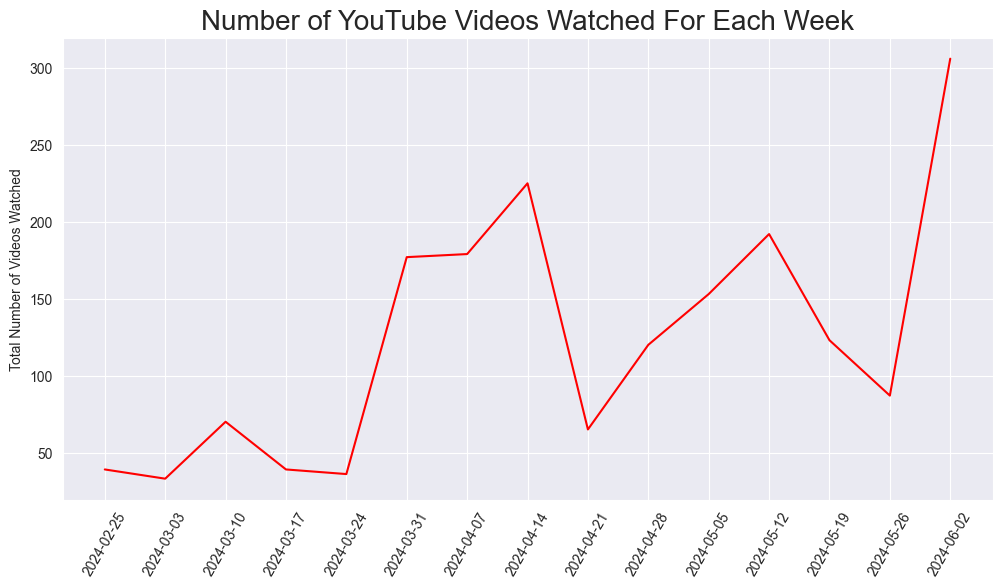

In [3]:
# Sort from oldest to newest
df_sorted = df.sort_values(by='date_time')

df_sorted['date_time'] = pd.to_datetime(df_sorted['date_time'])

# Set the 'date_time' column as the index
df_sorted.set_index('date_time', inplace=True)

# Resample the data by week and count the occurrences
weekly_counts = df_sorted.resample('W').size()
# Reset the index to make the 'date_time' column again
weekly_counts = weekly_counts.reset_index(name='frequency')
# Display the result
dates = weekly_counts['date_time'].astype('str')
videos = weekly_counts['frequency']

# Customize the graph to show
plt.figure(figsize=(12, 6), facecolor='white')
plt.title('Number of YouTube Videos Watched For Each Week', size=20)
plt.ylabel('Total Number of Videos Watched')
plt.xticks(rotation=60)
# Plot as a bar chart
plt.plot(dates, videos, color='red')
plt.show()

## Determine the specific days when the most videos were watched (regardless of whether some videos were re-watched)

In [95]:
# Sort from oldest to newest
df_sorted = df.sort_values(by='date_time')

df_sorted['date_time'] = pd.to_datetime(df_sorted['date_time'])

# Set the 'date_time' column as the index
df_sorted.set_index('date_time', inplace=True)
# Resample the data by dat and count the occurrences
daily_counts = df_sorted.resample('D').size()
# Reset the index to make the 'date_time' column again
daily_counts = daily_counts.reset_index(name='frequency')

daily_counts.sort_values('frequency', ascending=False)[:5]


,date_time,frequency
99,2024-05-29,171
43,2024-04-03,76
36,2024-03-27,58
101,2024-05-31,56
51,2024-04-11,55


## Calculate the average watch per day

In [126]:
print(f"The average number of videos watched per day from February 20 to June 02, 2024, is {round(daily_counts['frequency'].mean())} videos.")

The average number of videos watched per day from February 20 to June 02, 2024, is 18 videos.


## Identify the top 10 most viewed video watched on YouTube in my history from the past three months

Excluding YouTube Shorts or technically short videos

In [112]:
# Apply condition to filter the rows
condition = ((df_sorted['title'].str.contains('#shorts', case=False)) |
             (pd.to_timedelta(df_sorted['video_duration']).dt.total_seconds() <= 61))

# Only include the YouTube Regular Videos, negate the condition
filtered_df = df_sorted[~condition].reset_index(drop=True)
filtered_df = filtered_df.drop_duplicates(subset='title', keep='first')
filtered_df.sort_values('video_views', ascending=False)[['title', 'video_views']][:10]

,title,video_views
484,4 Non Blondes - What's Up (Official Music Video),1793508392
488,In The End [Official HD Music Video] - Linkin ...,1785079284
1326,Rick Astley - Never Gonna Give You Up (Officia...,1546359981
487,Evanescence - Bring Me To Life (Official HD Mu...,1380041318
227,BLACKPINK - '뚜두뚜두 (DDU-DU DDU-DU)' DANCE PRACT...,501677991
485,The Cranberries - Linger (Official Music Video),467786407
226,BLACKPINK - '붐바야(BOOMBAYAH)' DANCE PRACTICE VIDEO,313076452
1053,Four Seasons ~ Vivaldi,259340236
62,The Best of Mozart,259311782
313,Michael Bublé - Feeling Good [Official 4K Rema...,250843011


## Plot the ratio between regular YouTube videos and YouTube shorts

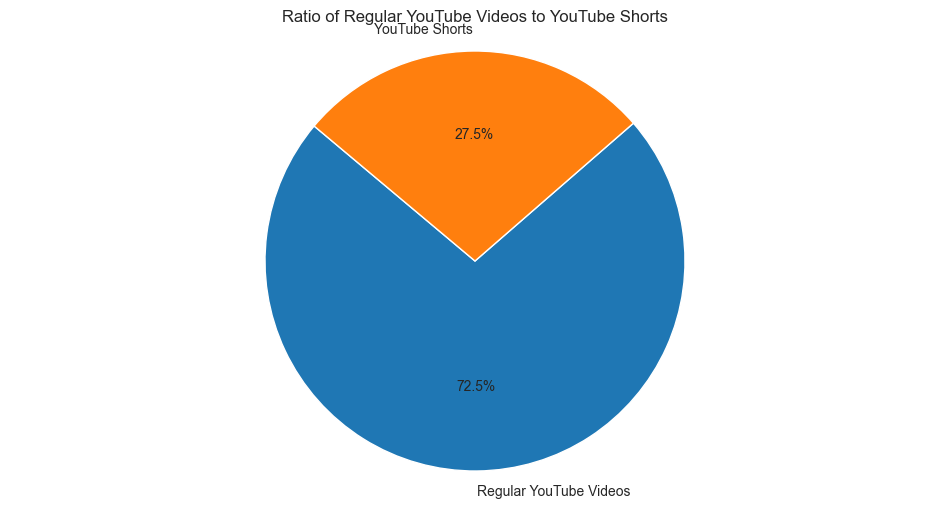

In [137]:
normal_or_shorts = df[['title', 'video_duration']]

video_shorts_count = ((df['title'].str.contains('#shorts', case=False)) |
         (pd.to_timedelta(df['video_duration']).dt.total_seconds() <= 61)).sum()

video_normal_count = normal_or_shorts.shape[0] - video_shorts_count

counts = [video_normal_count, video_shorts_count]
# Create a pie chart
plt.figure(figsize=(12, 6))
plt.pie(counts, labels=['Regular YouTube Videos', 'YouTube Shorts'], autopct='%1.1f%%', startangle=140)
plt.title('Ratio of Regular YouTube Videos to YouTube Shorts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [10]:
# Generate condition to filter YouTube Shorts in the dataset
condition =  ((df['title'].str.contains('#shorts', case=False)) |
         (pd.to_timedelta(df['video_duration']).dt.total_seconds() <= 61))
# Get the total number of YouTube Shorts
video_shorts_count = len(df[condition])
# Get the total number of Regular YouTube videos
regular_videos_count = len(df[~condition])
# Get the total number of days given the timeframe
total_number_of_days = daily_counts.shape[0]

# Calculate the average watch per day
video_shorts_avg = video_shorts_count / total_number_of_days
regular_videos_avg = regular_videos_count / total_number_of_days

print(f"The average number of YouTube Shorts watched per day from February 20 to June 02, 2024, is {round(video_shorts_avg)}.")

print(f"The average number of Regular YouTube videos watched per day from February 20 to June 02, 2024, is {round(regular_videos_avg)}.")


The average number of YouTube Shorts watched per day from February 20 to June 02, 2024, is 5.
The average number of Regular YouTube videos watched per day from February 20 to June 02, 2024, is 13.


## Determine the most favorite YouTube Videos by the number of times they were watched and by each month.

In [21]:
most_favorite_videos = df.groupby('title').size().reset_index(name='frequency')

# Sort by the 'count' column in descending order
sorted_counts = most_favorite_videos.sort_values('frequency', ascending=False)

# Determine the threshold count value for the top 10 counts
threshold_count = sorted_counts['frequency'].nlargest(10).min()

# Filter the rows to include all those with count values equal to or above the threshold
top_counts = sorted_counts[sorted_counts['frequency'] >= threshold_count]
top_counts

,title,frequency
388,F. Chopin : Nocturne in c sharp minor for viol...,34
269,Chopin - Ballade No. 1 in G Minor (1M special),34
858,Top 10 Most Difficult Piano Pieces,28
660,Piazzolla - Libertango (Piano Solo),24
797,The Best of Piano: The most beautiful classica...,24
286,Chopin - Waltz in C Sharp Minor (Op. 64 No. 2),24
274,Chopin - Etude Op. 10 No. 4 (Torrent),23
280,Chopin - Nocturne in C Sharp Minor (No. 20),21
783,Tchaikovsky - Valse Sentimentale,20
324,Czardas - Monti,17


## Determine the most favorite videos for each month

We define the 'favorite video' as having watch the video ten or more times.

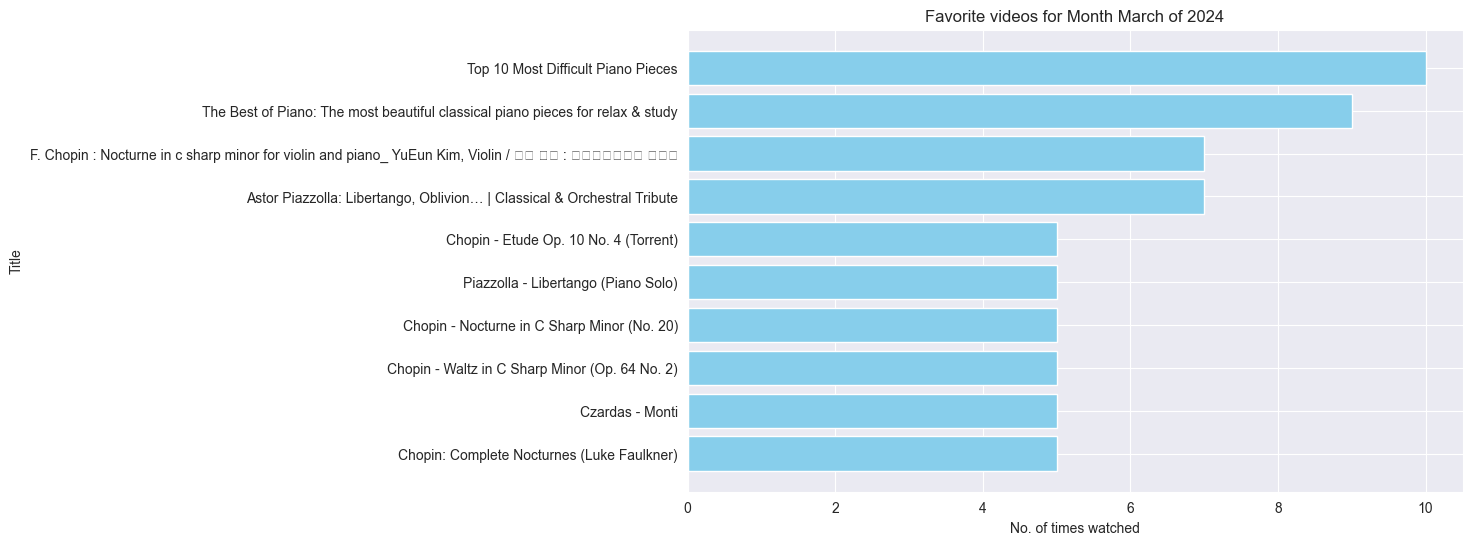

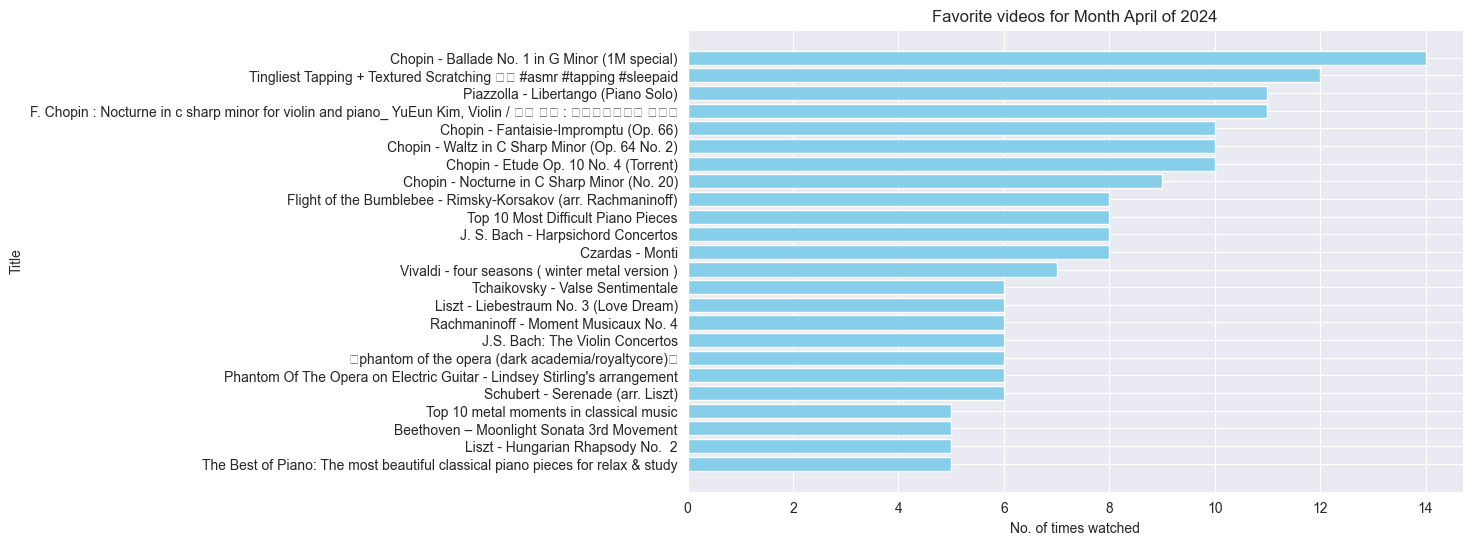

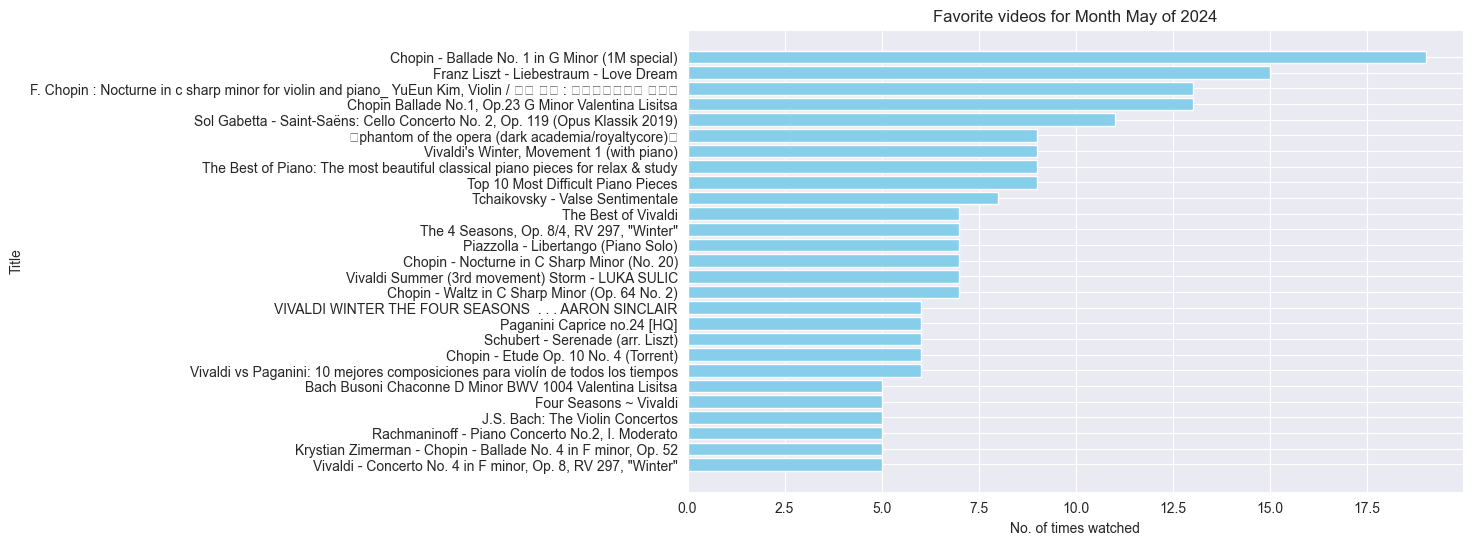

In [68]:
fav = df
fav['date_time'] = pd.to_datetime(fav['date_time'], format='%b %d, %Y, %I:%M:%S %p')

fav['month'] = fav['date_time'].dt.month
Months = list(fav['month'].unique())
Months.reverse()
dfs = {}
month_name = {
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June'
}

for month in Months:
    dfs[month] = fav[fav['month'] == month]
    
for month, monthly_df in dfs.items():
    most_favorite_video = monthly_df.groupby('title').size().reset_index(name='frequency')

    # Sort by the 'count' column in descending order
    sorted_counts = most_favorite_video.sort_values('frequency', ascending=False)
    # Filter the rows to include all those with count values equal to or above the threshold
    top_counts = sorted_counts[sorted_counts['frequency'] >= 5]
    
    if not top_counts.empty:
        titles = top_counts['title']
        watched = top_counts['frequency']
        plt.figure(figsize=(10, 6))
        plt.barh(titles, watched, color='skyblue')
        plt.xlabel('No. of times watched')
        plt.ylabel('Title')
        plt.title(f'Favorite videos for Month {month_name[month]} of 2024')
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
        plt.show()
        

We do not have favorite videos for February and June due to limited data availability. We started collecting data from February 20, allowing us only 8 days of data for February, and we have only 2 days of data for June.


## Identify the most common keyword in YouTube Titles

In [315]:
# Let's filter the stop words
stop_words = {
    'the', 'a', 'an', 'and', 'or', 'but', 'if', 'because', 'as', 'by', 'at', 'from', 'of', 'with',
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
    'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren',
    "weren't", 'won', "won't", 'wouldn', "wouldn't", "minor", "op", "for", "g", "f", "shorts",
    "'tis", "'twas", "a", "able", "about", "across", "after", "ain't", "all", "almost", "also", "am", "among", 
    "an", "and", "any", "are", "aren't", "as", "at", "be", "because", "been", "but", "by", "can", "can't", 
    "cannot", "could", "could've", "couldn't", "dear", "did", "didn't", "do", "does", "doesn't", "don't", 
    "either", "else", "ever", "every", "for", "from", "get", "got", "had", "has", "hasn't", "have", "he", 
    "he'd", "he'll", "he's", "her", "hers", "him", "his", "how", "how'd", "how'll", "how's", "however", "i", 
    "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "just", "least", 
    "let", "like", "likely", "may", "me", "might", "might've", "mightn't", "most", "must", "must've", 
    "mustn't", "my", "neither", "no", "nor", "not", "of", "off", "often", "on", "only", "or", "other", "our", 
    "own", "rather", "said", "say", "says", "shan't", "she", "she'd", "she'll", "she's", "should", "should've", 
    "shouldn't", "since", "so", "some", "than", "that", "that'll", "that's", "the", "their", "them", "then", 
    "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "tis", "to", "too", 
    "twas", "us", "wants", "was", "wasn't", "we", "we'd", "we'll", "asmr", "we're", "were", "weren't", "what", 
    "what'd", "what's", "when", "when", "when'd", "when'll", "reiki" ,"when's", "where", "where'd", "where'll", "where's", "one" ,
    "which", "while", "who", "who'd", "who'll", "who's", "whom", "why", "why'd", "why'll", "why's", "will", 
    "with", "won't", "would", "would've", "wouldn't", "yet", "you", "you'd", "you'll", "you're", "you've", 
    "your", "subscribe", "like", "comment", "share", "follow", "bell", "notification", "project",
    "check", "visit", "website", "video", "channel", "youtube", "link", "social", 
    "media", "http", "www", "com", "new", "thanks", "enjoy", "please", "join", "support", "de", "forget", "hope", "videos", "bwv"}

In [82]:
def create_wordcloud(data):
    # Generate a word cloud image
    word_cloud = WordCloud().generate_from_frequencies(data)
    
    # Display the generated image
    plt.figure(figsize=(10, 5))  # Adjust the size of the plot
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

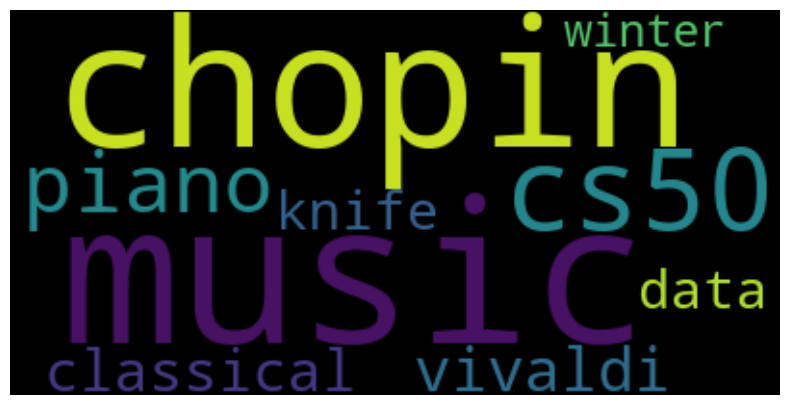

In [317]:
import re
from collections import defaultdict

def count_words(data_title, filter_words):
    words = defaultdict(int)
        
    for keywords in data_title['title']:
        for key in keywords.split():
            # Use regex to filter out non-alphabetic characters
            key = re.sub(r'[^a-zA-Z0-9]', '', key)
            if key and key.lower() not in filter_words and len(key) > 1:
                words[key.lower()] += 1
        
    # Convert dictionary to DataFrame
    return pd.DataFrame(list(words.items()), columns=['Word', 'Count'])

all_words = df
all_words = count_words(all_words.drop_duplicates(subset='title', keep='first'), stop_words)
all_words = all_words.sort_values(by='Count', ascending=False).head(9)

# Convert DataFrame to dictionary
word_freq_dict = dict(zip(all_words['Word'], all_words['Count']))

create_wordcloud(word_freq_dict)

## Determine the most common keyword or substring in all YouTube video tags.
Since I have watched some YouTube videos more than once, we must only count the tags in distinct values. Therefore, we need to filter out each distinct YouTube video by title.

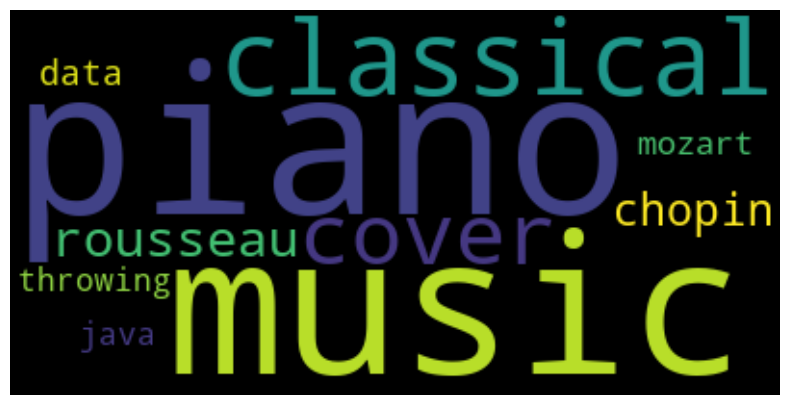

In [307]:
def count_tags(data_tags, filter_words):
    words = defaultdict(int)
        
    for tags in data_tags['video_tags']:
        if isinstance(tags, str):
            for tag in tags.split(','):
                for sub_tag in tag.split():
                    if sub_tag.lower() not in filter_words and sub_tag.lower().isalpha() and len(sub_tag.lower()) > 1: 
                        words[sub_tag.lower().strip()] += 1      
        
    # Convert dictionary to DataFrame
    return pd.DataFrame(list(words.items()), columns=['Word', 'Count'])

all_tags = df
all_tags = all_tags.drop_duplicates(subset='title', keep='first')
all_tags = count_tags(all_tags, stop_words)
all_tags = all_tags.sort_values(by='Count', ascending=False).head(10)

# Convert DataFrame to dictionary
word_freq_dict = dict(zip(all_tags['Word'], all_tags['Count']))

create_wordcloud(word_freq_dict)

## Determine the most common words in video description

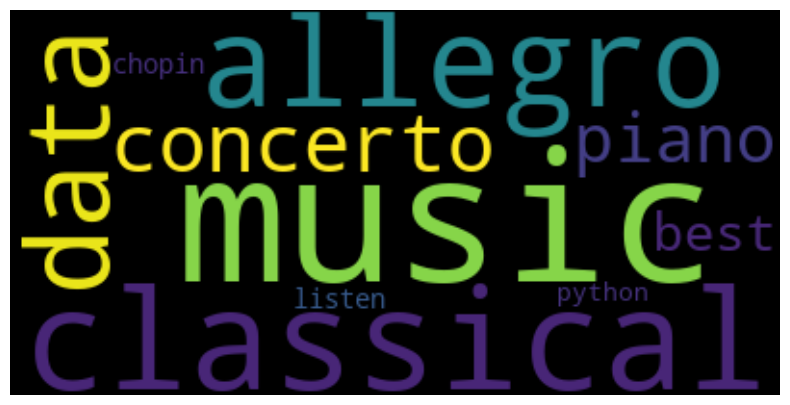

In [309]:
def count_tags(data_tags, filter_words):
    words = defaultdict(int)
                          
    for description in data_tags['video_description']:
        if isinstance(description, str):
            for word in description.split():
                if word.lower() not in filter_words and word.lower().isalpha() and len(word) > 1:
                    words[word.lower().strip()] += 1
        
    # Convert dictionary to DataFrame
    return pd.DataFrame(list(words.items()), columns=['Word', 'Count'])

all_description = df
all_description = all_description.drop_duplicates(subset='video_description', keep='first')
all_description = count_tags(all_description, stop_words)
all_description = all_description.sort_values(by='Count', ascending=False).head(10)

# Convert DataFrame to dictionary
word_freq_dict = dict(zip(all_description['Word'], all_description['Count']))

create_wordcloud(word_freq_dict)

## Identify the Favorite YouTube Channels

We define 'favorite youtube channel' as having watched more than 10 videos(re-watched videos aren't considered) in a certain channel

In [93]:
## create a function to count the occurrence of channel names
def count_channel(data, threshold=10):
    channels = defaultdict(int)
    
    for channel_name in data['channel_name']:
        channels[channel_name] += 1
        
    channel_df = pd.DataFrame(list(channels.items()), columns=['channel name', 'count'])
    
    channel_df = channel_df[channel_df['count'] > threshold]
    
    return channel_df

channel_data = df
channel_data = channel_data.drop_duplicates(subset='title', keep='first')
channel_data = count_channel(channel_data)

channel = channel_data.sort_values(by='count', ascending=False)
channel.reset_index(drop=True, inplace=True)
channel

,channel name,count
0,CS50,57
1,Jocie B ASMR,40
2,Rousseau,27
3,Kassia,26
4,Spirit Pond,25
5,Preston's ASMR,25
6,HALIDONMUSIC,23
7,Traum Piano,15
8,Josh Harmon,15
9,Adam Celadin,13


In [102]:
from datetime import timedelta

start = end = date = frequency = None
max_count = ctr = 0
sequences = []

for date, row in daily_counts.iterrows():
    frequency = row['frequency']
    if frequency == 0:
        ctr += 1
        if start is None:
            start = date
    else:
        if ctr > max_count:
            max_count = ctr
            end = date
            sequences.append((start, end))
        elif ctr == max_count and ctr != 0:
            end = date
            sequences.append((start, end))
        ctr = 0
        start = None

# Check if the longest consecutive sequence ends with the last date
if ctr > max_count:
    if frequency == 0:
        date = date + 1
    max_count = ctr
    end = date
    sequences.append((start, end))
elif ctr == max_count:
    end = date
    sequences.append((start, end))

reverse = list(reversed(sequences))
x = reverse[0][0]
y = reverse[0][1]

for i, pair in enumerate(reverse[1:], start=1):
    if pair[1] - pair[0] != y - x:
        del reverse[i:]
        break
sequences = reverse

for start, end in sequences:
    start_date = str(daily_counts.iloc[start]['date_time'].date())
    end_date = str(daily_counts.iloc[end]['date_time'].date() - timedelta(days=1))
    print(f"You had not watched on YouTube from {start_date} until {end_date}")
days = end - start
print(f"That makes it {days} days!")
    

You had not watched on YouTube from 2024-02-21 until 2024-02-23
That makes it 3 days!


## Identify the Oldest Video uploaded on YouTube in your watch History

In [104]:
oldest = df.sort_values(by='video_date_upload', ascending=True)
oldest = oldest.drop_duplicates(subset='title', keep='first')
oldest.reset_index(inplace=True)
oldest[['title', 'video_date_upload']].head(10)

,title,video_date_upload
0,Maksim plays Original of Flight of the Bumble Bee,2006-08-24 10:18:20
1,"the answer to life, universe and everything",2008-05-09 19:17:11
2,"Mozart Symphony #40 in G Minor, K 550 - 1. Mol...",2008-08-11 07:22:50
3,Tchaikovsky - Sleeping Beauty Waltz,2008-08-19 07:41:51
4,Mussorgsky - Night on Bald Mountain,2008-09-19 06:29:43
5,Björk - It's Oh So Quiet (HQ),2008-10-04 08:49:33
6,Yuja Wang plays the Flight of the Bumble-Bee (...,2008-10-09 14:47:14
7,"Antonio Vivaldi - 'Allegro non molto' from ""Wi...",2008-10-21 01:10:09
8,Franz Liszt - Liebestraum - Love Dream,2008-10-24 06:12:47
9,Niccolo Paganini - La campanella,2008-10-27 17:25:32


## Determine the most like and most commented YouTube video in Watch history

In [113]:
most_liked = filtered_df.sort_values(by='video_likes', ascending=False)
most_liked = most_liked.drop_duplicates(subset='title', keep='first')
most_liked.reset_index(inplace=True)
most_liked[['title', 'video_likes']].head(10)

,title,video_likes
0,Rick Astley - Never Gonna Give You Up (Officia...,17662413
1,In The End [Official HD Music Video] - Linkin ...,11715284
2,Evanescence - Bring Me To Life (Official HD Mu...,9830059
3,4 Non Blondes - What's Up (Official Music Video),7597894
4,BLACKPINK - '뚜두뚜두 (DDU-DU DDU-DU)' DANCE PRACT...,5687946
5,Do This Everyday To Lose Weight | 2 Weeks Shre...,4161098
6,BLACKPINK - '붐바야(BOOMBAYAH)' DANCE PRACTICE VIDEO,3204233
7,BLACKPINK - DANCE PRACTICE VIDEO,2969190
8,Michael Bublé - Feeling Good [Official 4K Rema...,2899047
9,Chopin - Nocturne op.9 No.2,2555863


In [114]:
most_commented = filtered_df.sort_values(by='video_comment_count', ascending=False)
most_commented  = most_commented.drop_duplicates(subset='title', keep='first')
most_commented.reset_index(inplace=True)
most_commented [['title', 'video_comment_count']].head(10)


,title,video_comment_count
0,Rick Astley - Never Gonna Give You Up (Officia...,2341878
1,In The End [Official HD Music Video] - Linkin ...,441924
2,Evanescence - Bring Me To Life (Official HD Mu...,296902
3,4 Non Blondes - What's Up (Official Music Video),205914
4,BLACKPINK - '뚜두뚜두 (DDU-DU DDU-DU)' DANCE PRACT...,184828
5,Do This Everyday To Lose Weight | 2 Weeks Shre...,153193
6,Chopin - Nocturne op.9 No.2,129912
7,BLACKPINK - DANCE PRACTICE VIDEO,91795
8,BLACKPINK - '붐바야(BOOMBAYAH)' DANCE PRACTICE VIDEO,76855
9,The Cranberries - Linger (Official Music Video),74217


## Determine YouTube Videos uploaded on the same day as your birthday

In [115]:
from datetime import datetime

# Given birthdate as a string
birth_date_str = '2005-07-21'

# Convert the string to a datetime object
birth_date = datetime.strptime(birth_date_str, '%Y-%m-%d')
same_day = df
# Convert the 'video_date_upload' column to datetime objects
same_day['video_date_upload'] = pd.to_datetime(same_day['video_date_upload'])

# Filter the DataFrame for videos uploaded on the same month and day as the birthdate, ignoring the year
same_day_videos = df[(df['video_date_upload'].dt.month == birth_date.month) &
                     (df['video_date_upload'].dt.day == birth_date.day)]

same_day_videos

,title,url,video_duration,channel_name,channel_url,date_time,video_date_upload,video_category,video_views,video_likes,video_comment_count,video_description,video_tags,month
293,"Violin Concerto in F Minor, RV 297 (""Winter"" f...",https://www.youtube.com/watch?v=sPwvVQY7SgM,00:03:25,Stuttgart Chamber Orchestra - Topic,https://www.youtube.com/channel/UCJrQ3Xg0S3O8f...,2024-05-28 21:50:57,2021-07-21 10:01:23,Music,367649,3804,0,Provided to YouTube by Mediaphon\n\nViolin Con...,Stuttgart Chamber Orchestra Martin Sieghart Ra...,5
1522,WHO'S SMARTER? | College Dropouts vs Harvard S...,https://www.youtube.com/watch?v=SbeKi7jow0s,00:15:54,Brandon Walsh,https://www.youtube.com/channel/UCagjd6FJVi3nx...,2024-03-29 09:01:16,2022-07-21 19:58:16,Entertainment,7419007,168852,7721,Are Harvard students really as smart as people...,"Walsh,brandon,kennedy,claudia,family",3


## What time do you often watch on YouTube?

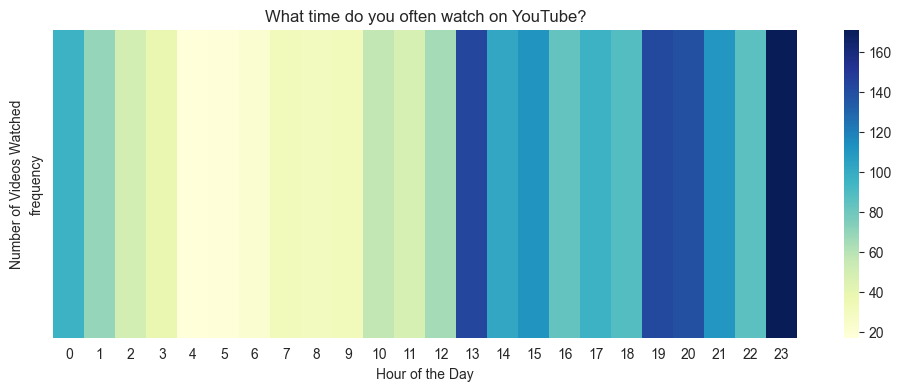

In [116]:
import seaborn as sns

# Assuming `df` is your DataFrame
freq_viewed = df

# Convert the 'date_time' column to datetime
freq_viewed['date_time'] = pd.to_datetime(freq_viewed['date_time'])

# Set the 'date_time' column as the index
freq_viewed.set_index('date_time', inplace=True)

# Resample the data by hour and count the occurrences
freq_viewed = freq_viewed.resample('H').size()

# Reset the index to get the hour as a column
freq_viewed = freq_viewed.reset_index(name='frequency')

# Extract the hour from the 'date_time' column
freq_viewed['hour'] = freq_viewed['date_time'].dt.hour

# Aggregate data by hour
hourly_data = freq_viewed.groupby('hour')['frequency'].sum().reset_index()

# Create the heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(hourly_data.set_index('hour').T, cmap="YlGnBu", annot=False)
plt.title('What time do you often watch on YouTube?')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Videos Watched')
plt.show()

## What day of the week do you often watch on YouTube?

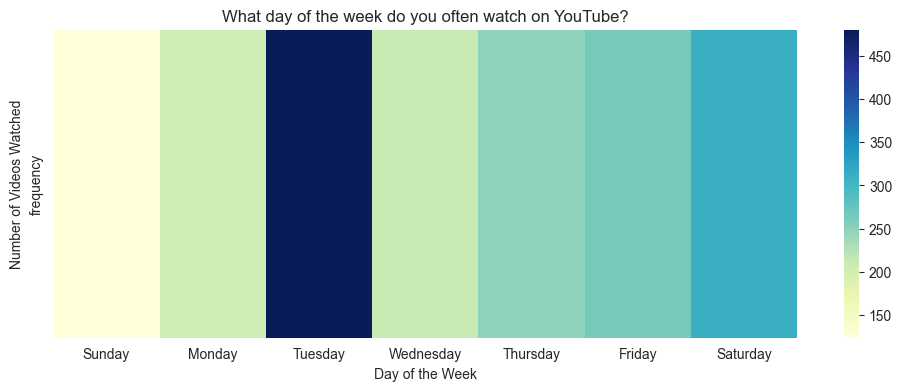

In [122]:
each_day = df

# Convert the 'date_time' column to datetime
each_day['date_time'] = pd.to_datetime(each_day['date_time'])

# Set the 'date_time' column as the index
each_day.set_index('date_time', inplace=True)

# Resample the data by hour and count the occurrences
each_day = each_day.resample('D').size()

# Reset the index to get the day as a column
each_day = each_day.reset_index(name='frequency')

# Extract the hour from the 'date_time' column
each_day['day_of_week'] = each_day['date_time'].dt.dayofweek

# Aggregate data by hour
hourly_data = each_day.groupby('day_of_week')['frequency'].sum().reset_index()

# Create the heatmap
plt.figure(figsize=(12, 4))
day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.heatmap(hourly_data.set_index('day_of_week').T, cmap="YlGnBu", annot=False, xticklabels=day_names)
plt.title('What day of the week do you often watch on YouTube?')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Videos Watched')
plt.show()

## Identify the frequency of videos watched base on its duration(minutes)

In [ ]:
total_time = pd.read_csv('youtube_data.csv')

def time_convert(x):
    h,m,s = map(int,x.split(':'))
    return (h*60+m)*60+s

total_time['video_duration'] = total_time['video_duration'].astype('str').apply(time_convert)
total_time['video_duration'] = total_time['video_duration'] / 60

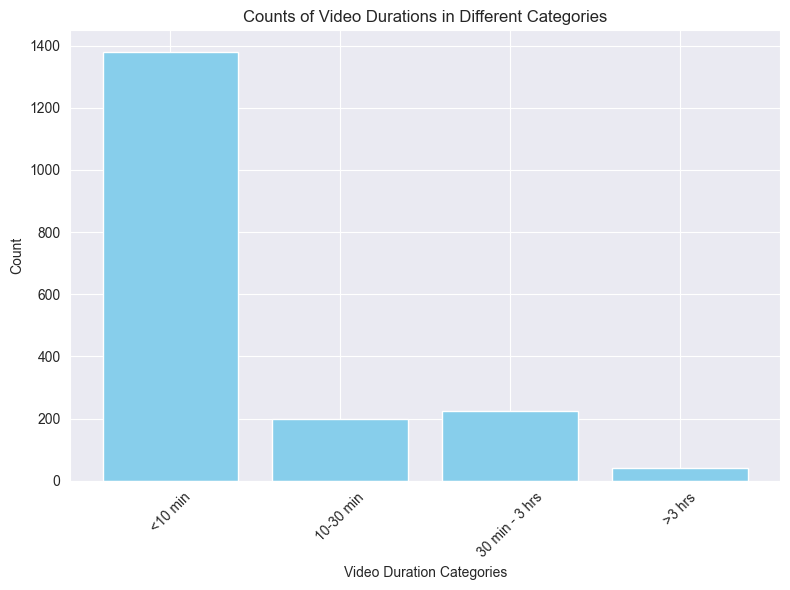

In [221]:
short_videos = len(total_time[total_time['video_duration'] <= 10])
medium_videos = len(total_time[(total_time['video_duration'] > 10) & (total_time['video_duration'] <= 30)])
long_videos = len(total_time[(total_time['video_duration'] > 30) & (total_time['video_duration'] <= 180)])
very_long_videos = len(total_time[total_time['video_duration'] > 180])

vid_durations = [short_videos, medium_videos, long_videos, very_long_videos]
categories = ['<10 min', '10-30 min', '30 min - 3 hrs', '>3 hrs']

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, vid_durations, color='skyblue')
plt.xlabel('Video Duration Categories')
plt.ylabel('Count')
plt.title('Counts of Video Durations in Different Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 

## Identify the frequency of video counts by year base on the uploaded time of each video

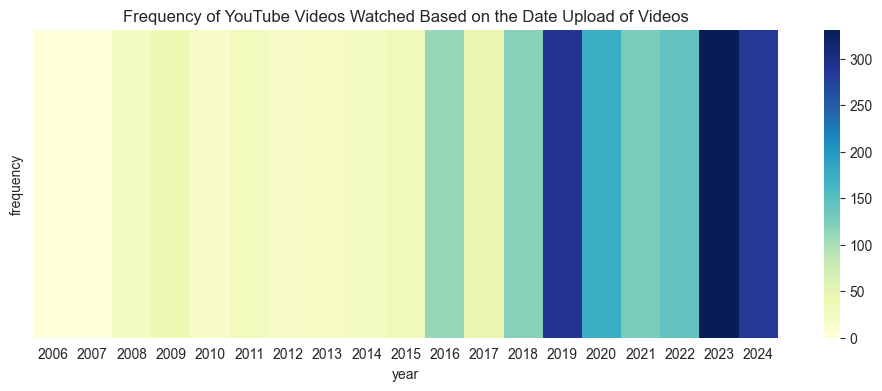

In [182]:
each_year = pd.read_csv('youtube_data.csv')

# Convert the 'date_time' column to datetime
each_year['video_date_upload'] = pd.to_datetime(each_year['video_date_upload'])

# Set the 'date_time' column as the index
each_year.set_index('video_date_upload', inplace=True)

# Resample the data by hour and count the occurrences
each_year = each_year.resample('Y').size()

# Reset the index to get the day as a column
each_year = each_year.reset_index(name='frequency')

# Extract the hour from the 'date_time' column
each_year['year'] = each_year['video_date_upload'].dt.year

# Aggregate data by hour
by_year = each_year.groupby('year')['frequency'].sum().reset_index()

# Create the heatmap
plt.figure(figsize=(12, 4))
years = list(by_year['year'].unique())
sns.heatmap(by_year.set_index('year').T, cmap="YlGnBu", annot=False, xticklabels=years)
plt.title('Frequency of YouTube Videos Watched Based on the Date Upload of Videos')
plt.show()

## Frequency of videos watched by each category

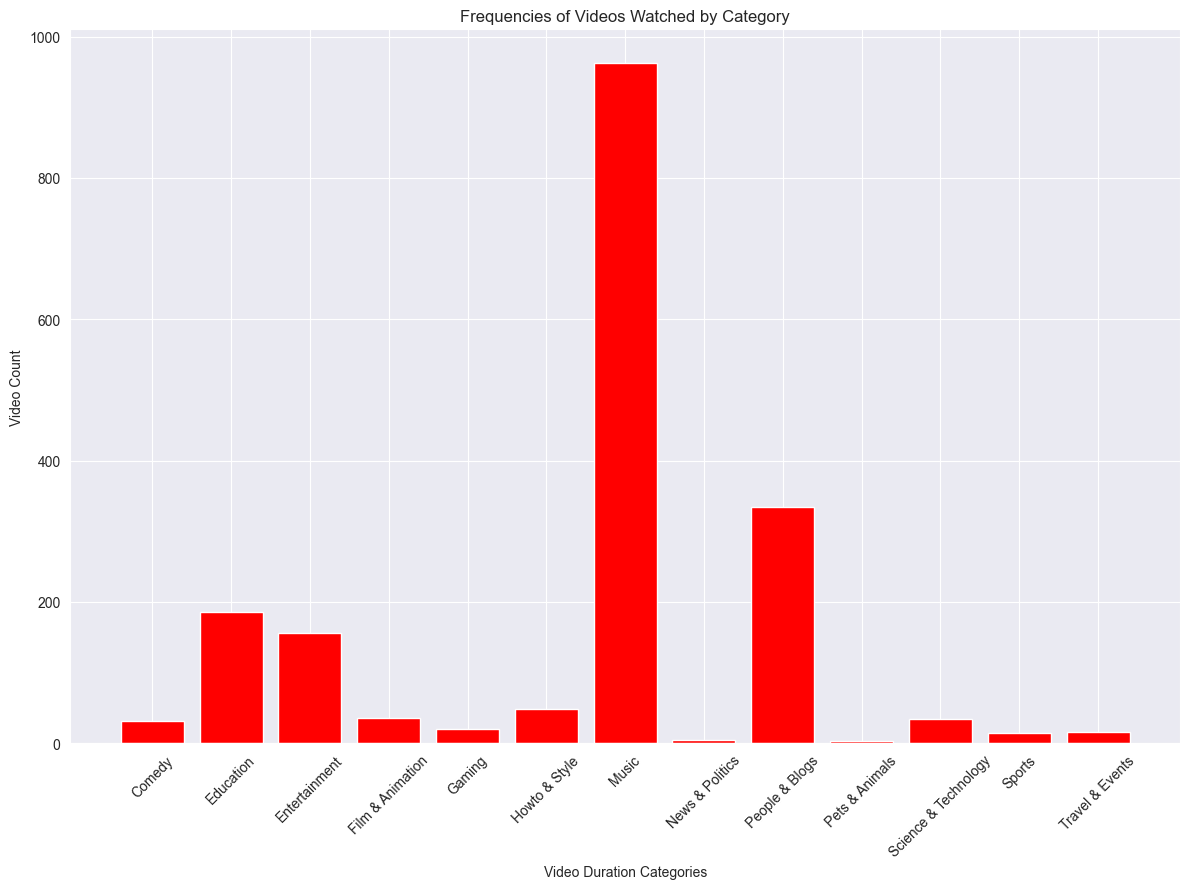

In [295]:
ratio_category = pd.read_csv('youtube_data.csv')

ratio_category = ratio_category.groupby('video_category').size()
ratio_category = ratio_category.reset_index(name='frequency')

ratio_category.sort_values('frequency', ascending=False)

vid_category = ratio_category['video_category']
freq = ratio_category['frequency']
# Plotting the bar chart
plt.figure(figsize=(12, 9))
plt.bar(vid_category.tolist(), freq.tolist(), color='red')

plt.xlabel('Video Duration Categories')
plt.ylabel('Video Count')
plt.title('Frequencies of Videos Watched by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 

## Determine the total watch time of YouTube videos for each category

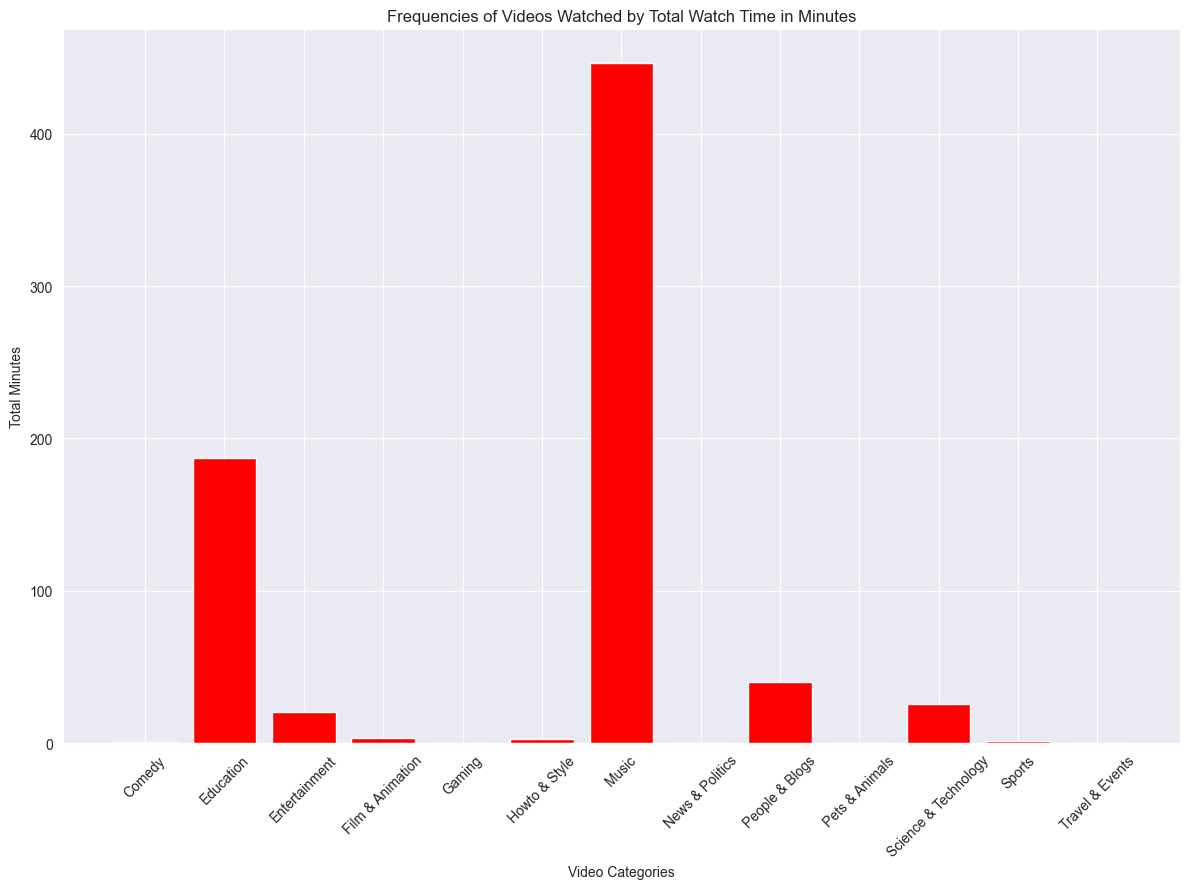

In [296]:
vid_category = vid_category.tolist()

total_watch_category = {
    key:None for key in vid_category
}

for category in vid_category:
    total_watch_category[category] = total_time[total_time['video_category'] == category]['video_duration'].sum()

# Convert dictionary to DataFrame
category_watch_times = pd.DataFrame(list(total_watch_category.items()), columns=['category', 'total_watch_time'])

category_watch_times['total_watch_time'] /= 60

# Plotting the bar chart
plt.figure(figsize=(12, 9))
plt.bar(category_watch_times['category'].tolist(), category_watch_times['total_watch_time'].tolist(), color='red')

plt.xlabel('Video Categories')
plt.ylabel('Total Minutes')
plt.title('Frequencies of Videos Watched by Total Watch Time in Minutes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 
    

# Conclusion

Based on my analysis of my YouTube usage data, I have derived several key insights:

**Actual Watch Hours**: While YouTube data indicates a total of 730 watch hours, my actual usage is likely closer to 400 hours. This discrepancy arises because I frequently skip or do not fully watch many videos.

**Watching Patterns and Averages**: I have gained a deeper understanding of my viewing habits. This reflection has helped me identify how I allocate my time on the platform by examining my watching patterns and average watch times.

**Favorite Content**: I have identified my favorite YouTube videos and channels. This awareness allows me to recognize the types of content I am most engaged with and enjoy the most.

**Interesting Insights**: This analysis of my YouTube history data has revealed several interesting insights. For example, I can see trends in the types of videos I watch, the time of day I am most active, and other behavioral patterns.

**Realistic Usage**: My YouTube history data realistically reflects my usage, primarily for listening to music. This indicates that YouTube serves as a significant source of audio content for me. Well, YouTube is the only platform where I listen to music.

Overall, this analysis has provided a comprehensive view of my YouTube usage. It highlights my viewing habits and preferences that truly reflects with my realistic usage. These patterns can help me to manage my time better and make more informed choices about my media consumption.

